# CLUSTERING OF COUNTRIES

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram,cut_tree
import math

## Reading and Understanding the Data

In [2]:
#Reading dataset
df=pd.read_csv('Country-data.csv')
# Checking the shape of the data set
print('The shape of the dataframe is:',df.shape)
df.head()

The shape of the dataframe is: (167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# Analysing the number of missing values
round(100*df.isnull().sum()/len(df),2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

In [4]:
# Checking for duplicate rows
df.duplicated(subset=None, keep='first').sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [6]:
df['country'].nunique()

167

### Data Manipulation

In [7]:
# Changing the variables that are expressed as percenateg of gdpp to whole numbers
df['exports']=df['exports']/100*df['gdpp']
df['health']=df['health']/100*df['gdpp']
df['imports']=df['imports']/100*df['gdpp']
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [8]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


**Outliers are present in most of the columns and they have to be treated after further analysis**

## EDA

### Analysing the distribution of Continuous Variables

In [9]:
#function for box plot
def bx_plot(*args,data): 
    
    m=math.ceil(len(args)/2)  # getting the length f arguments to determine the shape of subplots                   
    fig,axes = plt.subplots(m,2,squeeze=False, figsize = (16, 6*m))
    ax_li = axes.flatten()       # flattening the numpy array returned by subplots
    i=0
    for col in args:
        sns.boxplot(y=data[col],ax=ax_li[i])  # plotting the box plot
        ax_li[i].set_title(col)
        #ax_li[i].set_yscale('log')
        plt.tight_layout()
        i=i+1
    

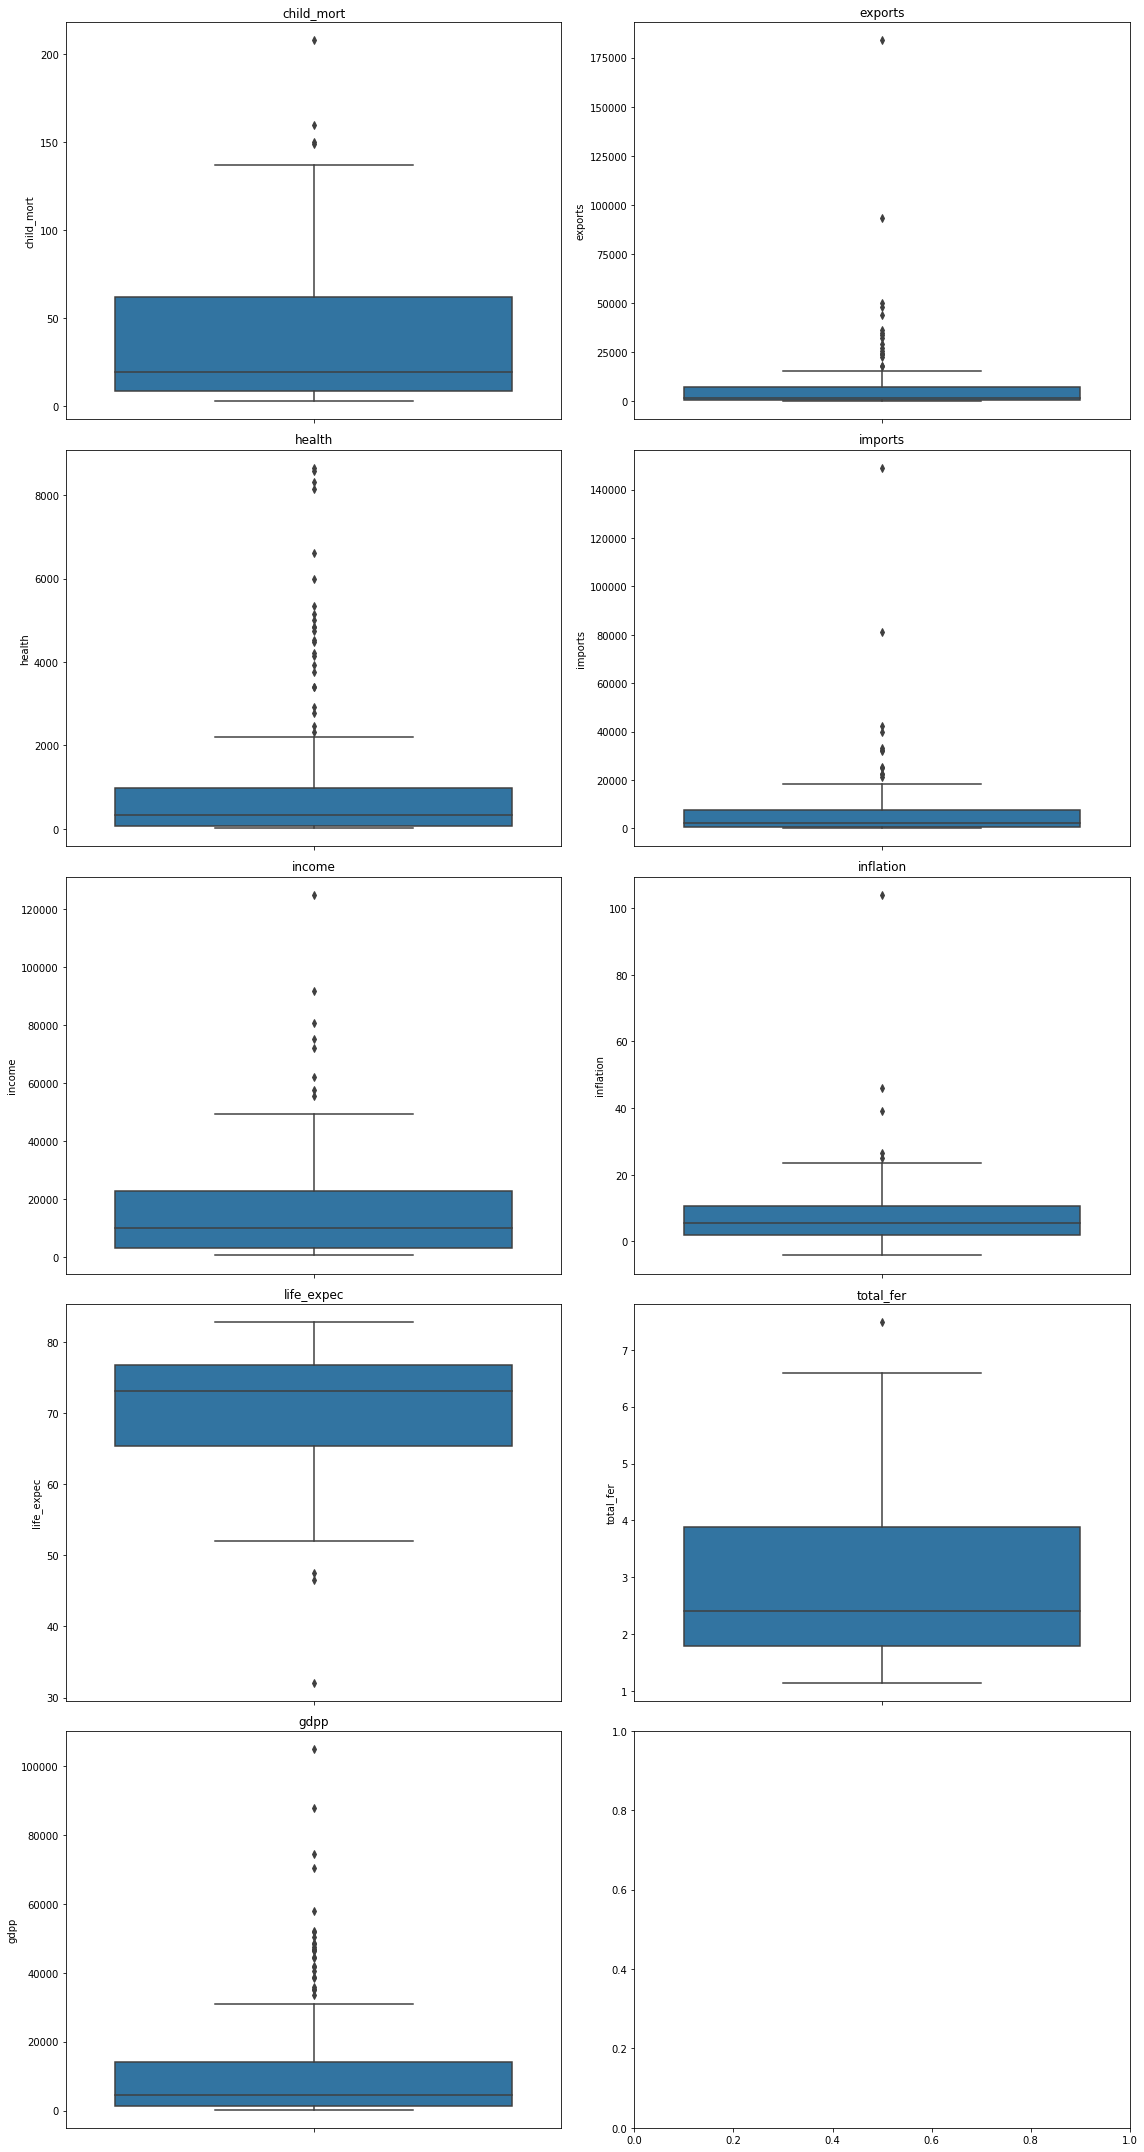

In [10]:
col=[col for col in df.columns.tolist() if col not in 'country']# Selecting all the variables except country
bx_plot(*col,data=df)

**Presence of outliers are confirmed by visualisation also.  However these are retained for performing PCA**

### Correlation Matrix

The correlation between different numeric variables are visualized to check for Multicollinearity

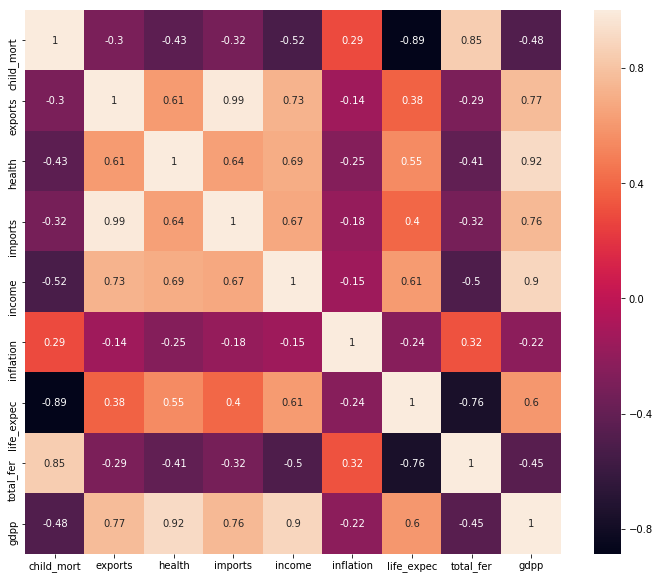

In [11]:
plt.figure(figsize = (12,10)) 
sns.heatmap(df.corr(),annot = True)

 We observe a strong positive correlation between child mortality and fertility, imports and exports,
 income and gdp, health and gdpp. There is also a strong negative correlation between child mortality and life expectancy,life expectancy and total fertility

## Preprocessing Data

In [12]:
X=df.copy() # creating a copy of the original dataframe
y=X.pop('country')# Slicing the data

In [13]:
scaler = StandardScaler()  
x = scaler.fit_transform(X) # scaling

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Principal Component Analysis

In [14]:
pca = PCA(random_state=100)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
# determing the variance explained by each of the Principal Components
pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

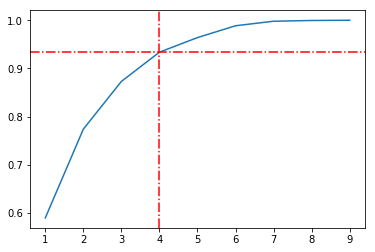

In [16]:
# Plotting the cumulative varoiance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1,len(var_cumu)+1), var_cumu)
plt.axhline(y=.933, color='r', linestyle='-.')
plt.axvline(x=4, color='r', linestyle='-.')


PCA with 4 components can explain about 93% of variance. Hence, the number of components required for analysis is chosen as 4

In [17]:
pc = PCA(n_components=4, random_state=100) # Selecting 4 PCs for further analysis
newdata = pc.fit_transform(x)
newdata.shape

(167, 4)

In [18]:
df_pca = pd.DataFrame(newdata, columns=["PC1", "PC2","PC3","PC4"])  # Creating a dataframe of PCs
df_pca.head()

,PC1,PC2,PC3,PC4
0,-2.635575,1.472267,-0.549489,-0.242326
1,-0.024206,-1.429892,-0.014123,0.450645
2,-0.459557,-0.675495,0.959355,0.218456
3,-2.722630,2.172332,0.600215,-0.433978
4,0.648597,-1.023437,-0.257430,0.289201


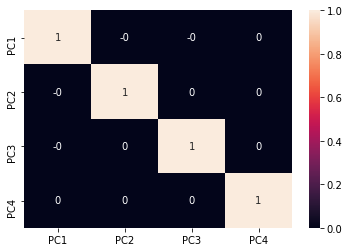

In [19]:
#Checking the correlation Matrix for Principal components
sns.heatmap(round(df_pca.corr(),2),annot = True)

As expected, the Principal Components are not correlated to each other

### Checking the distribution of Pricipal Components

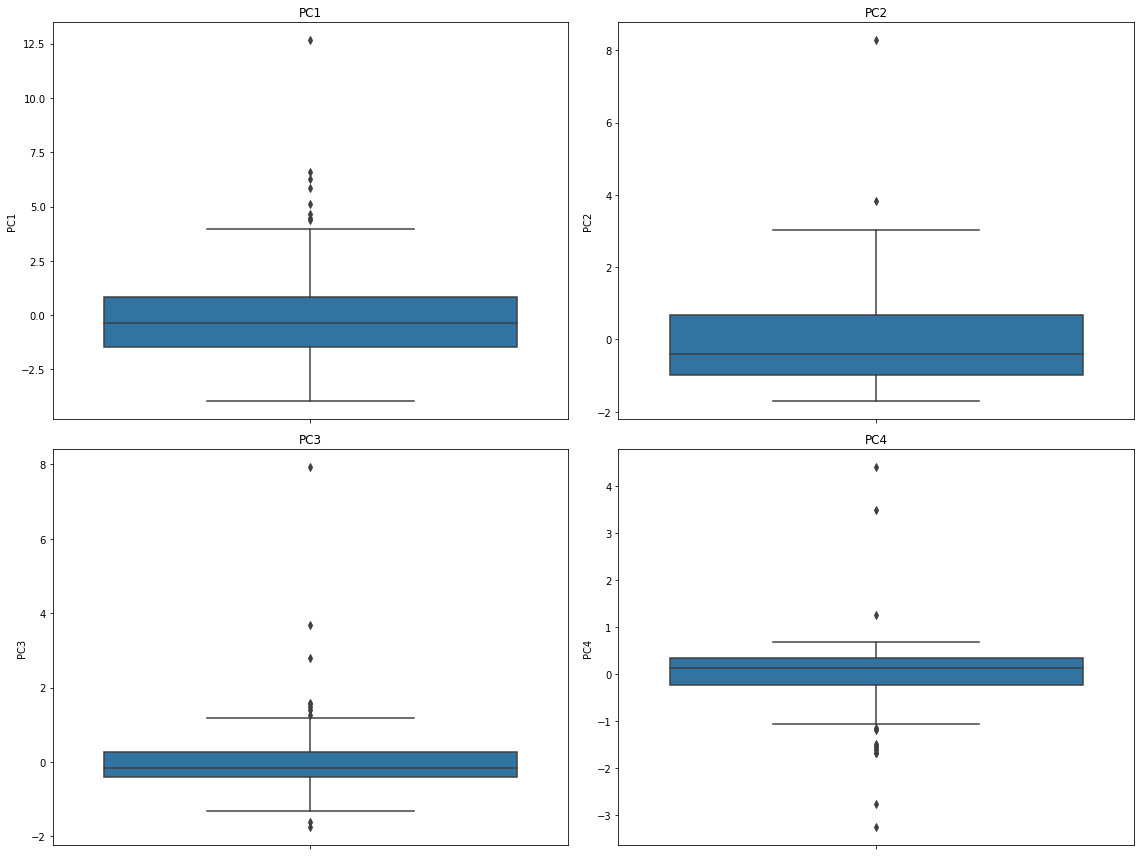

In [20]:
col_pca=df_pca.columns.tolist()
bx_plot(*col_pca,data=df_pca)

***The outliers are present in the principal components and they have to be removed to facitate cluster formation.***

In [21]:
#Removing outliers
q=df_pca['PC1'].quantile(0.95)
df_pca=df_pca[df_pca['PC1']<=q]

q=df_pca['PC2'].quantile(0.98)
df_pca=df_pca[df_pca['PC2']<=q]

q2=df_pca['PC3'].quantile(0.85)
q1=df_pca['PC3'].quantile(0.05)
df_pca=df_pca[(df_pca['PC3']<=q2) & (df_pca['PC3']>=q1)]

q2=df_pca['PC4'].quantile(0.99)
q1=df_pca['PC4'].quantile(0.13)
df_pca=df_pca[(df_pca['PC4']<=q2) & (df_pca['PC4']>=q1)]


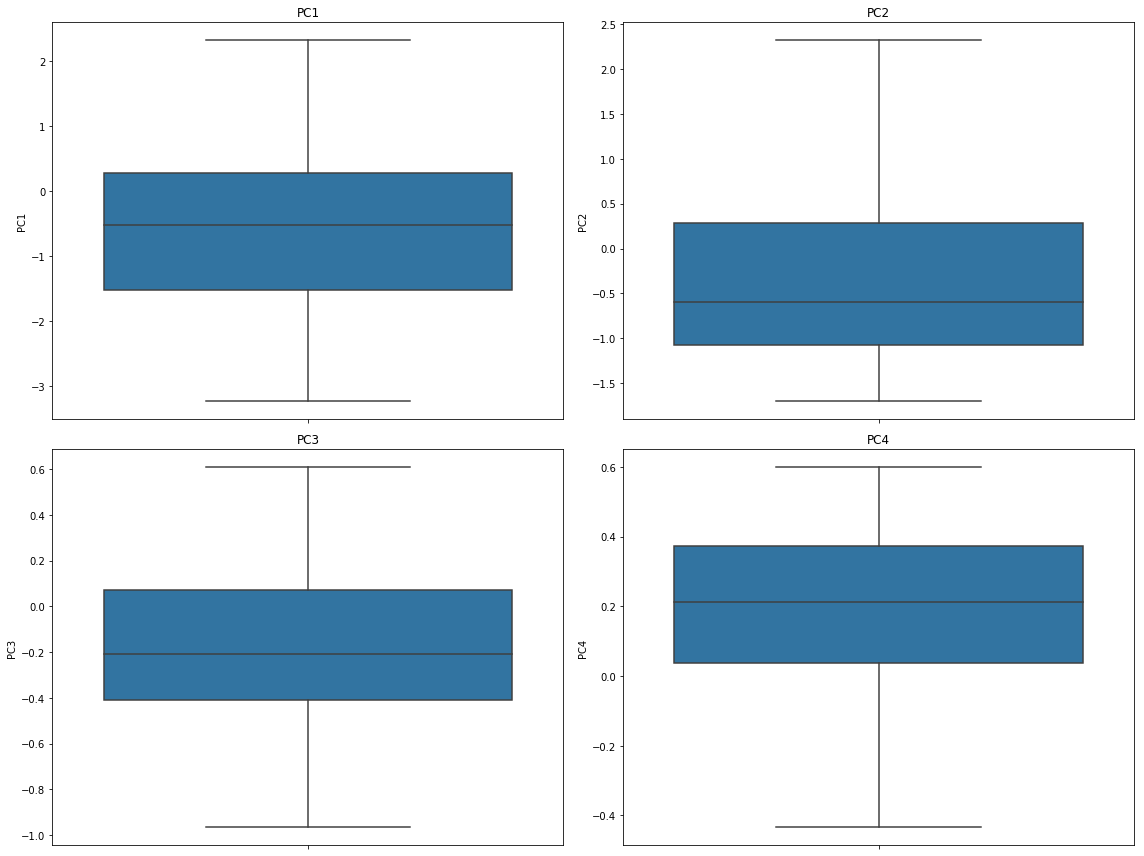

In [22]:
#Plotting box plot to check for outliers again
bx_plot(*col_pca,data=df_pca)

In [23]:
#Checking the shape of the dataframe after outlier removal
df_pca.shape

(105, 4)

### Hopkin's test

Performing Hopkin's test to check if the data points can form clusters

In [24]:
# Hopkin's test
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [25]:
hopkins(df_pca)

0.7870084117937627

From the above hopkin's statistic, it is clear that the retained principal components can form clusters

## Clustering

### K-means clustering

The principal components determined in the previous section are used for clustering

In [26]:
df_kmeans=df_pca.copy()  # creating a copy of thre Principal Components Dataframe
df_kmeans.head()

,PC1,PC2,PC3,PC4
0,-2.635575,1.472267,-0.549489,-0.242326
1,-0.024206,-1.429892,-0.014123,0.450645
3,-2.722630,2.172332,0.600215,-0.433978
4,0.648597,-1.023437,-0.257430,0.289201
6,-0.334555,-1.271889,0.190564,0.500247


#### Choosing the optimum value of k

For n_clusters=2, the silhouette score is 0.5495750058441985
For n_clusters=3, the silhouette score is 0.4204254227896811
For n_clusters=4, the silhouette score is 0.40441708525469294
For n_clusters=5, the silhouette score is 0.40880226600889447
For n_clusters=6, the silhouette score is 0.36970019547368127
For n_clusters=7, the silhouette score is 0.369119493299311
For n_clusters=8, the silhouette score is 0.3490563913099229


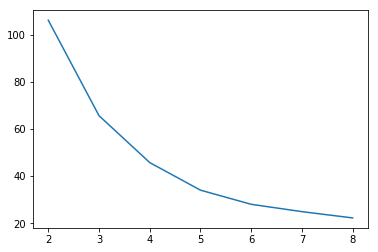

In [27]:
# Ebow-curve & Silhouette analysis
ssd = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_kmeans)
    
    cluster_labels = kmeans.labels_
    ssd.append(kmeans.inertia_)
    
    silhouette_avg = silhouette_score(df_kmeans, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))  #print the silhouette score

plt.plot(range_n_clusters,ssd) # plot the SSDs for each n_clusters

From the above results, 3 clusters are chosen as optimum.However, clustering is also performed for k=4 to check how the clusters vary.

#### Clustering with k=3

In [28]:
df_kmeans_3=df_kmeans.copy()
kmeans = KMeans(n_clusters=3, max_iter=50,random_state=100)
kmeans.fit(df_kmeans_3)
df_kmeans_3['cluster_id'] = kmeans.labels_# assign the label

In [29]:
df_kmeans_3=pd.concat([y,df_kmeans_3],axis=1) # Concatenating the country
df_out=df_kmeans_3[df_kmeans_3.isnull().any(axis=1)] # Storing the countries identified as outliers in a separate dataframe
df_out.shape


(62, 6)

In [30]:
df_kmeans_3.head()

,country,PC1,PC2,PC3,PC4,cluster_id
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,1.0
1,Albania,-0.024206,-1.429892,-0.014123,0.450645,0.0
2,Algeria,NaN,NaN,NaN,NaN,NaN
3,Angola,-2.722630,2.172332,0.600215,-0.433978,1.0
4,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,0.0


In [31]:
df_kmeans_3.dropna(inplace=True) # Dropping null values
df_kmeans_3.shape

(105, 6)

In [32]:
df_kmeans_3['cluster_id']=df_kmeans_3['cluster_id'].astype(int)  # Converting cluster id back to integer
df_kmeans_3.head()

,country,PC1,PC2,PC3,PC4,cluster_id
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,1
1,Albania,-0.024206,-1.429892,-0.014123,0.450645,0
3,Angola,-2.722630,2.172332,0.600215,-0.433978,1
4,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,0
6,Armenia,-0.334555,-1.271889,0.190564,0.500247,2


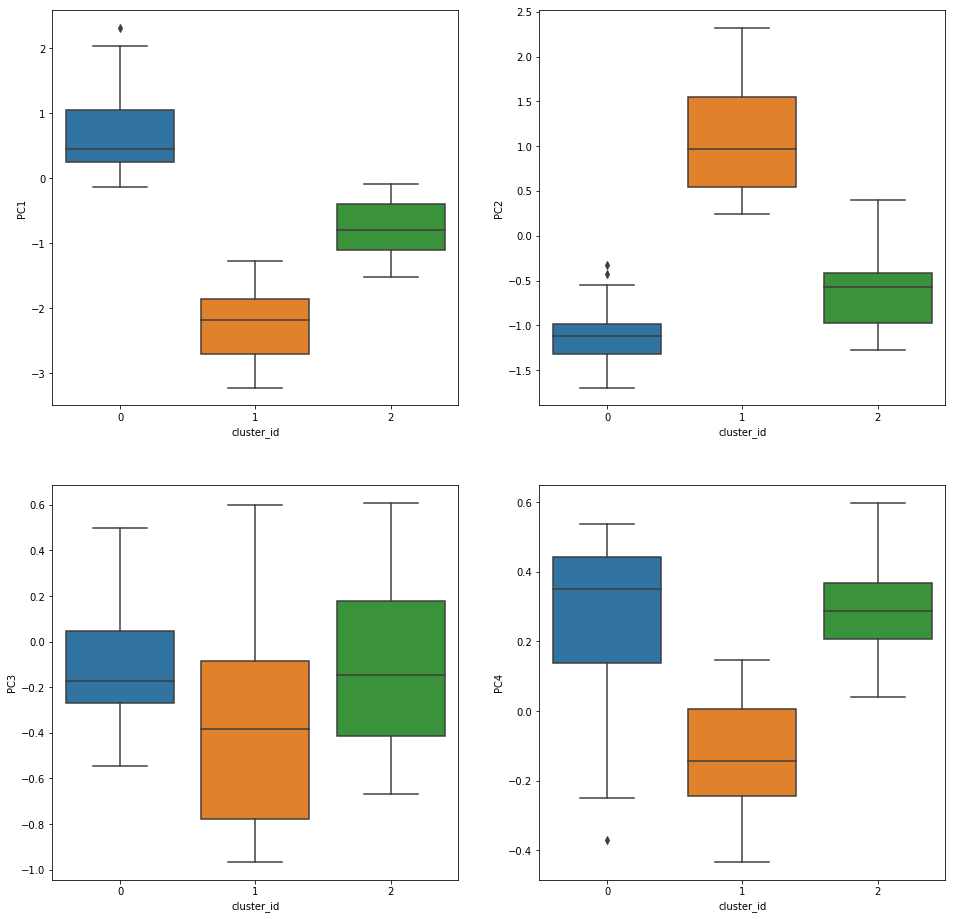

In [33]:
### Analysing the distribution of Principal Components across clusters
fig,axes = plt.subplots(2,2,squeeze=False, figsize = (16, 16))
sns.boxplot(x='cluster_id', y='PC1', data=df_kmeans_3, ax=axes[0][0])
sns.boxplot(x='cluster_id', y='PC2', data=df_kmeans_3, ax=axes[0][1])
sns.boxplot(x='cluster_id', y='PC3', data=df_kmeans_3, ax=axes[1][0])
sns.boxplot(x='cluster_id', y='PC4', data=df_kmeans_3, ax=axes[1][1])

 It is observed that PC1 and PC2 are well separated in three clusters and PC3 and PC4 overlap to a ceratin extent

In [34]:
df_kmeans_3=df_kmeans_3.merge(df, on= 'country') # Merging with original dataframe
df_kmeans_3.head()

,country,PC1,PC2,PC3,PC4,cluster_id,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,1,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,-0.024206,-1.429892,-0.014123,0.450645,0,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Angola,-2.722630,2.172332,0.600215,-0.433978,1,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
3,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,0,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200
4,Armenia,-0.334555,-1.271889,0.190564,0.500247,2,18.1,669.76,141.6800,1458.660,6700,7.77,73.3,1.69,3220


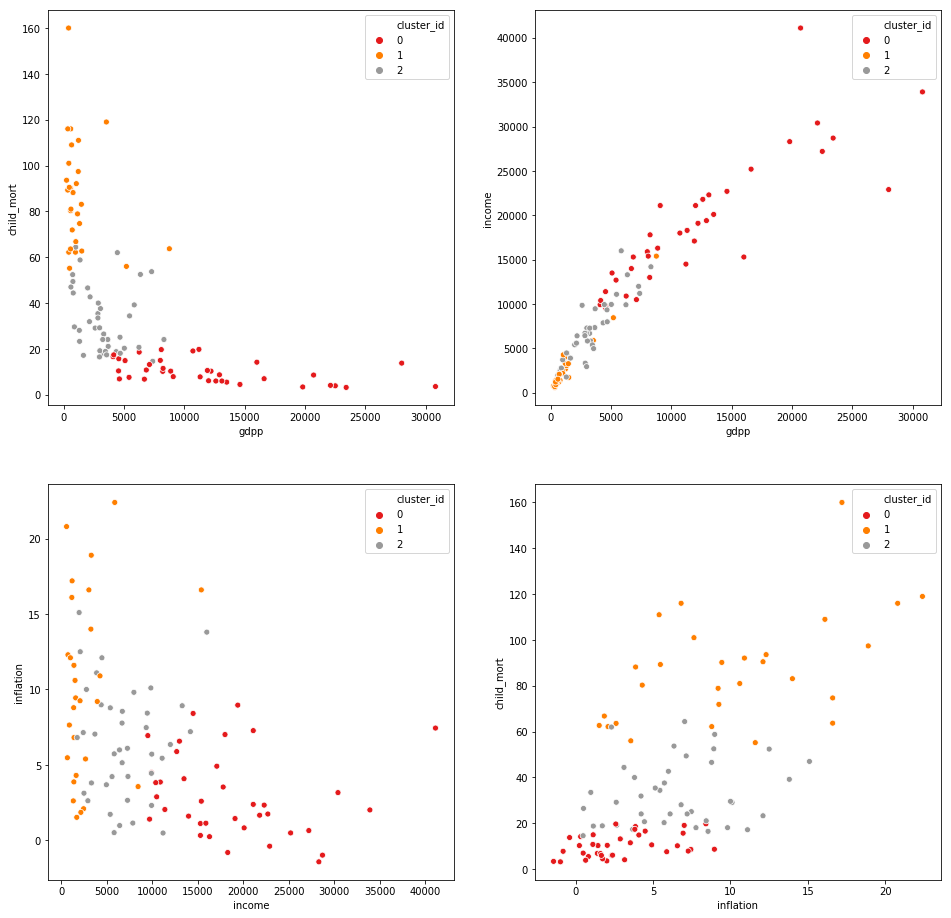

In [35]:
# Visualising the scatterplot of important variables
fig,axes = plt.subplots(2,2,squeeze=False, figsize = (16, 16))

sns.scatterplot(x="gdpp", y="child_mort",data=df_kmeans_3, hue = "cluster_id",palette='Set1',ax=axes[0][0])
sns.scatterplot(x="gdpp", y="income",data=df_kmeans_3, hue = "cluster_id",palette='Set1',ax=axes[0][1])
sns.scatterplot(x="income", y="inflation",data=df_kmeans_3, hue = "cluster_id",palette='Set1',ax=axes[1][0])
sns.scatterplot(x="inflation", y="child_mort",data=df_kmeans_3, hue = "cluster_id",palette='Set1',ax=axes[1][1])


#### Clustering with k=4

In [36]:
df_kmeans_4=df_kmeans.copy()
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(df_kmeans_4)

df_kmeans_4['cluster_id'] = kmeans.labels_ # assign the label
df_kmeans_4.head()

,PC1,PC2,PC3,PC4,cluster_id
0,-2.635575,1.472267,-0.549489,-0.242326,3
1,-0.024206,-1.429892,-0.014123,0.450645,2
3,-2.722630,2.172332,0.600215,-0.433978,3
4,0.648597,-1.023437,-0.257430,0.289201,1
6,-0.334555,-1.271889,0.190564,0.500247,2


In [37]:
df_kmeans_4=pd.concat([y,df_kmeans_4],axis=1)
df_out1=df_kmeans_4[df_kmeans_4.isnull().any(axis=1)]
df_kmeans_4.dropna(inplace=True)
df_out1.shape

(62, 6)

In [38]:
df_kmeans_4.head()

,country,PC1,PC2,PC3,PC4,cluster_id
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,3.0
1,Albania,-0.024206,-1.429892,-0.014123,0.450645,2.0
3,Angola,-2.722630,2.172332,0.600215,-0.433978,3.0
4,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,1.0
6,Armenia,-0.334555,-1.271889,0.190564,0.500247,2.0


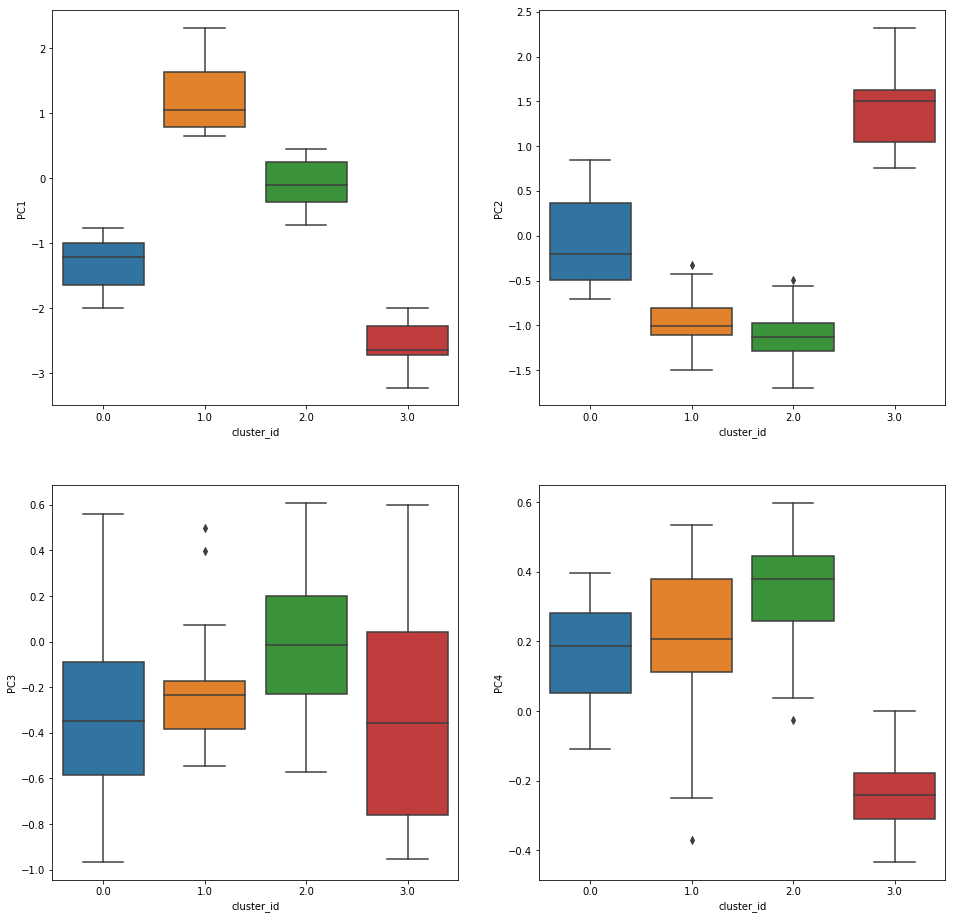

In [39]:
### Analysing the distribution of Principal Components across clusters
fig,axes = plt.subplots(2,2,squeeze=False, figsize = (16, 16))
sns.boxplot(x='cluster_id', y='PC1', data=df_kmeans_4, ax=axes[0][0])
sns.boxplot(x='cluster_id', y='PC2', data=df_kmeans_4, ax=axes[0][1])
sns.boxplot(x='cluster_id', y='PC3', data=df_kmeans_4, ax=axes[1][0])
sns.boxplot(x='cluster_id', y='PC4', data=df_kmeans_4, ax=axes[1][1])

Though PC1 and PC2 are separated across clusters, a high overlap is observed for PC3 and PC4

In [40]:
df_kmeans_4=df_kmeans_4.merge(df, on= 'country') # Merging with original data frame
df_kmeans_4.head()

,country,PC1,PC2,PC3,PC4,cluster_id,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,3.0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,-0.024206,-1.429892,-0.014123,0.450645,2.0,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Angola,-2.722630,2.172332,0.600215,-0.433978,3.0,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
3,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,1.0,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200
4,Armenia,-0.334555,-1.271889,0.190564,0.500247,2.0,18.1,669.76,141.6800,1458.660,6700,7.77,73.3,1.69,3220


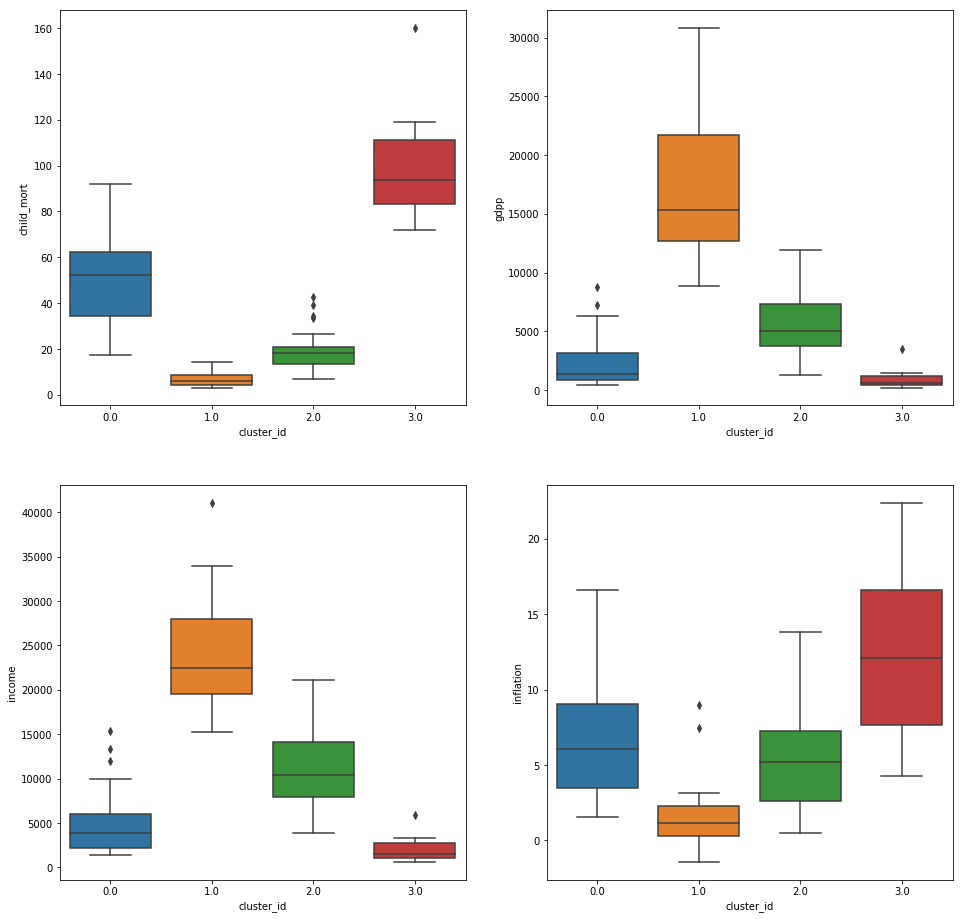

In [41]:
fig,axes = plt.subplots(2,2,squeeze=False, figsize = (16, 16))
sns.boxplot(x='cluster_id', y='child_mort', data=df_kmeans_4, ax=axes[0][0])
sns.boxplot(x='cluster_id', y='gdpp', data=df_kmeans_4, ax=axes[0][1])
sns.boxplot(x='cluster_id', y='income', data=df_kmeans_4, ax=axes[1][0])
sns.boxplot(x='cluster_id', y='inflation', data=df_kmeans_4, ax=axes[1][1])

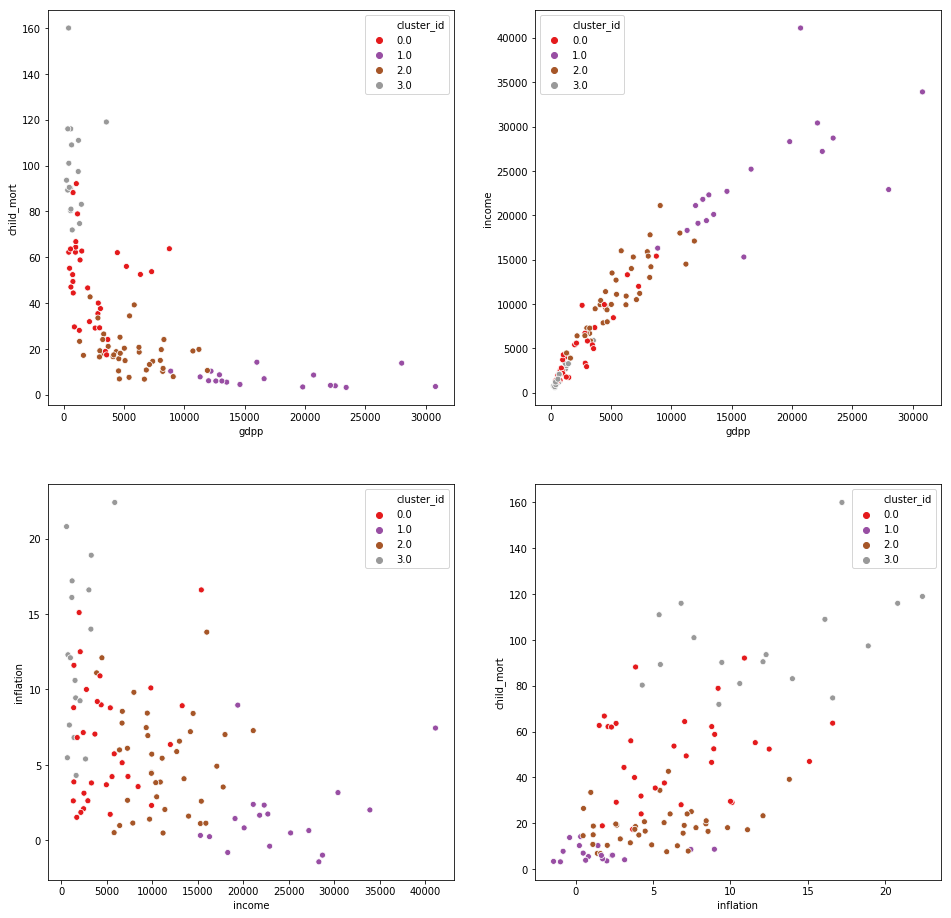

In [42]:
fig,axes = plt.subplots(2,2,squeeze=False, figsize = (16, 16))

sns.scatterplot(x="gdpp", y="child_mort",data=df_kmeans_4, hue = "cluster_id",ax=axes[0][0],palette='Set1')
sns.scatterplot(x="gdpp", y="income",data=df_kmeans_4, hue = "cluster_id",palette='Set1',ax=axes[0][1])
sns.scatterplot(x="income", y="inflation",data=df_kmeans_4, hue = "cluster_id",palette='Set1',ax=axes[1][0])
sns.scatterplot(x="inflation", y="child_mort",data=df_kmeans_4, hue = "cluster_id",palette='Set1',ax=axes[1][1])

We observe that the clusters are well separated when k=3.

## Hierarchical Clustering

### Simple Linkage Hierarchical Clustering

In [43]:
df_sl=df_pca.copy()  # Create a copy of Principal components Dataframe
df_sl.head()

,PC1,PC2,PC3,PC4
0,-2.635575,1.472267,-0.549489,-0.242326
1,-0.024206,-1.429892,-0.014123,0.450645
3,-2.722630,2.172332,0.600215,-0.433978
4,0.648597,-1.023437,-0.257430,0.289201
6,-0.334555,-1.271889,0.190564,0.500247


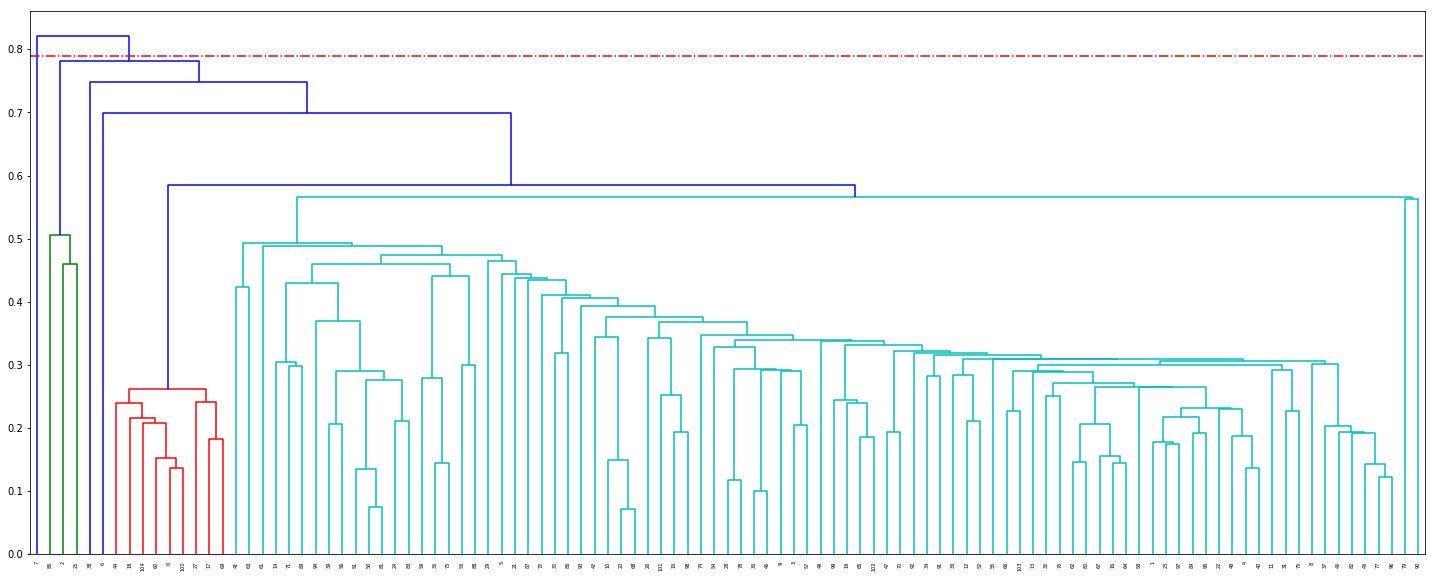

In [44]:
fig = plt.figure(figsize=(25, 10))
mergings = linkage(df_sl, method="single", metric='euclidean')  # Computing single linkage
dendrogram(mergings)  # plotting Dendrograms
plt.axhline(y=0.79, color='r', linestyle='-.')
plt.show()   

From theabove graph, it is clear that cutting the dendrogram at 0.79 will give 3 clusters. However, it is also evident that first cluster will have only one country, second will have only three countries and all other countries will form a cluster. Hence this method can't be further used for cluster anlaysis

### Complete linkage Hierarchical clustering

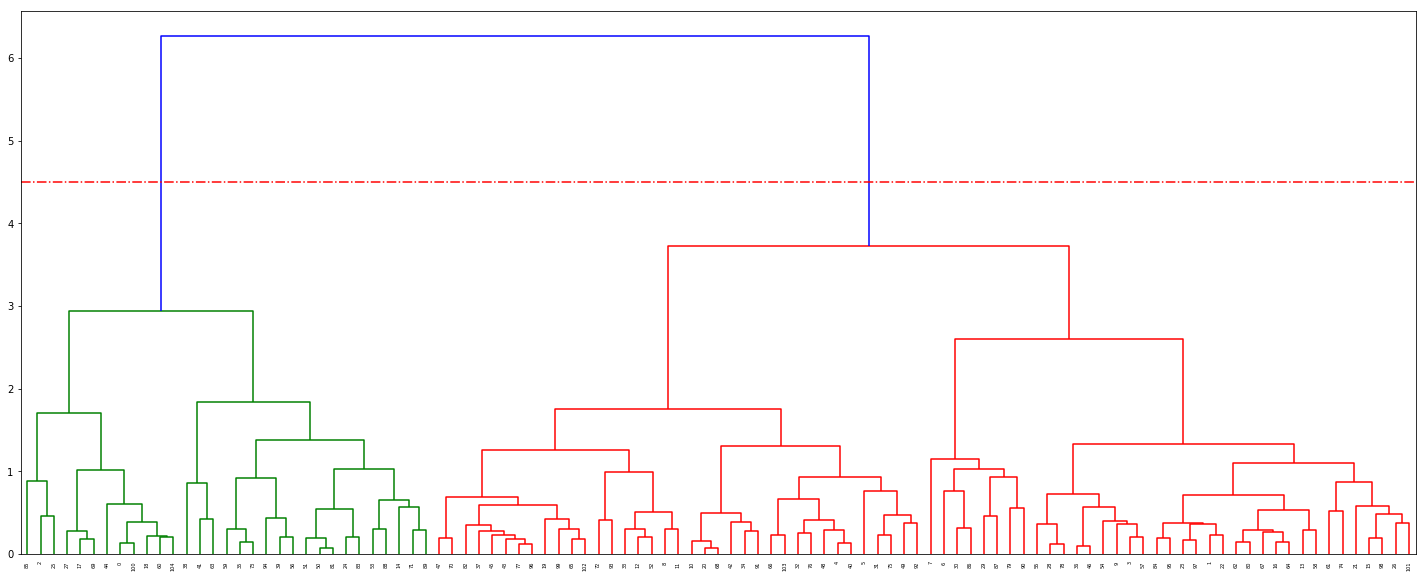

In [45]:
fig = plt.figure(figsize=(25, 10))
df_cl=df_pca.copy()

mergings = linkage(df_cl, method="complete", metric='euclidean')
dendrogram(mergings)
plt.axhline(y=4.5, color='r', linestyle='-.')
plt.show() 

Cutting the dendrogram at 4.5 will give 3 clusters

In [46]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )

df_cl['cluster_labels'] = cluster_labels # assign cluster labels
df_cl.head()

,PC1,PC2,PC3,PC4,cluster_labels
0,-2.635575,1.472267,-0.549489,-0.242326,0
1,-0.024206,-1.429892,-0.014123,0.450645,1
3,-2.722630,2.172332,0.600215,-0.433978,0
4,0.648597,-1.023437,-0.257430,0.289201,1
6,-0.334555,-1.271889,0.190564,0.500247,2


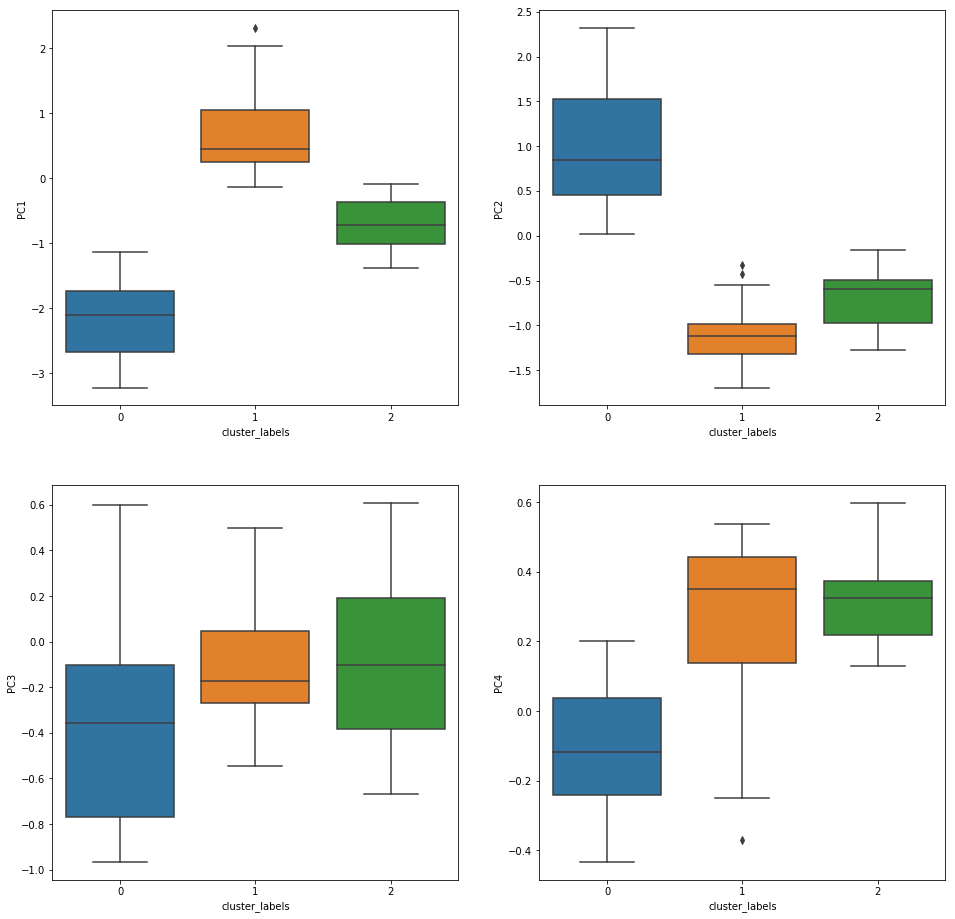

In [47]:
# Visualising the distribution of PCs
fig,axes = plt.subplots(2,2,squeeze=False, figsize = (16, 16))
sns.boxplot(x='cluster_labels', y='PC1', data=df_cl, ax=axes[0][0])
sns.boxplot(x='cluster_labels', y='PC2', data=df_cl, ax=axes[0][1])
sns.boxplot(x='cluster_labels', y='PC3', data=df_cl, ax=axes[1][0])
sns.boxplot(x='cluster_labels', y='PC4', data=df_cl, ax=axes[1][1])

PC1 andPC2 are well separated. However, PC3 and PC4 overlap across clusters

In [48]:
df_cl=pd.concat([y,df_cl],axis=1)  # Concatenating countries
df_cl.head()

,country,PC1,PC2,PC3,PC4,cluster_labels
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,0.0
1,Albania,-0.024206,-1.429892,-0.014123,0.450645,1.0
2,Algeria,NaN,NaN,NaN,NaN,NaN
3,Angola,-2.722630,2.172332,0.600215,-0.433978,0.0
4,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,1.0


In [49]:
df_out_cl=df_cl[df_cl.isnull().any(axis=1)]  #Removing outliers and storing as a separate dataframe
df_out_cl.shape

(62, 6)

In [50]:
df_cl.dropna(inplace=True)
df_cl.shape

(105, 6)

In [51]:
df_cl['cluster_labels']=df_cl['cluster_labels'].astype(int)  # Converting cluster id back to integer
df_cl.head()

,country,PC1,PC2,PC3,PC4,cluster_labels
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,0
1,Albania,-0.024206,-1.429892,-0.014123,0.450645,1
3,Angola,-2.722630,2.172332,0.600215,-0.433978,0
4,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,1
6,Armenia,-0.334555,-1.271889,0.190564,0.500247,2


C:\Users\admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\admin\Anaconda

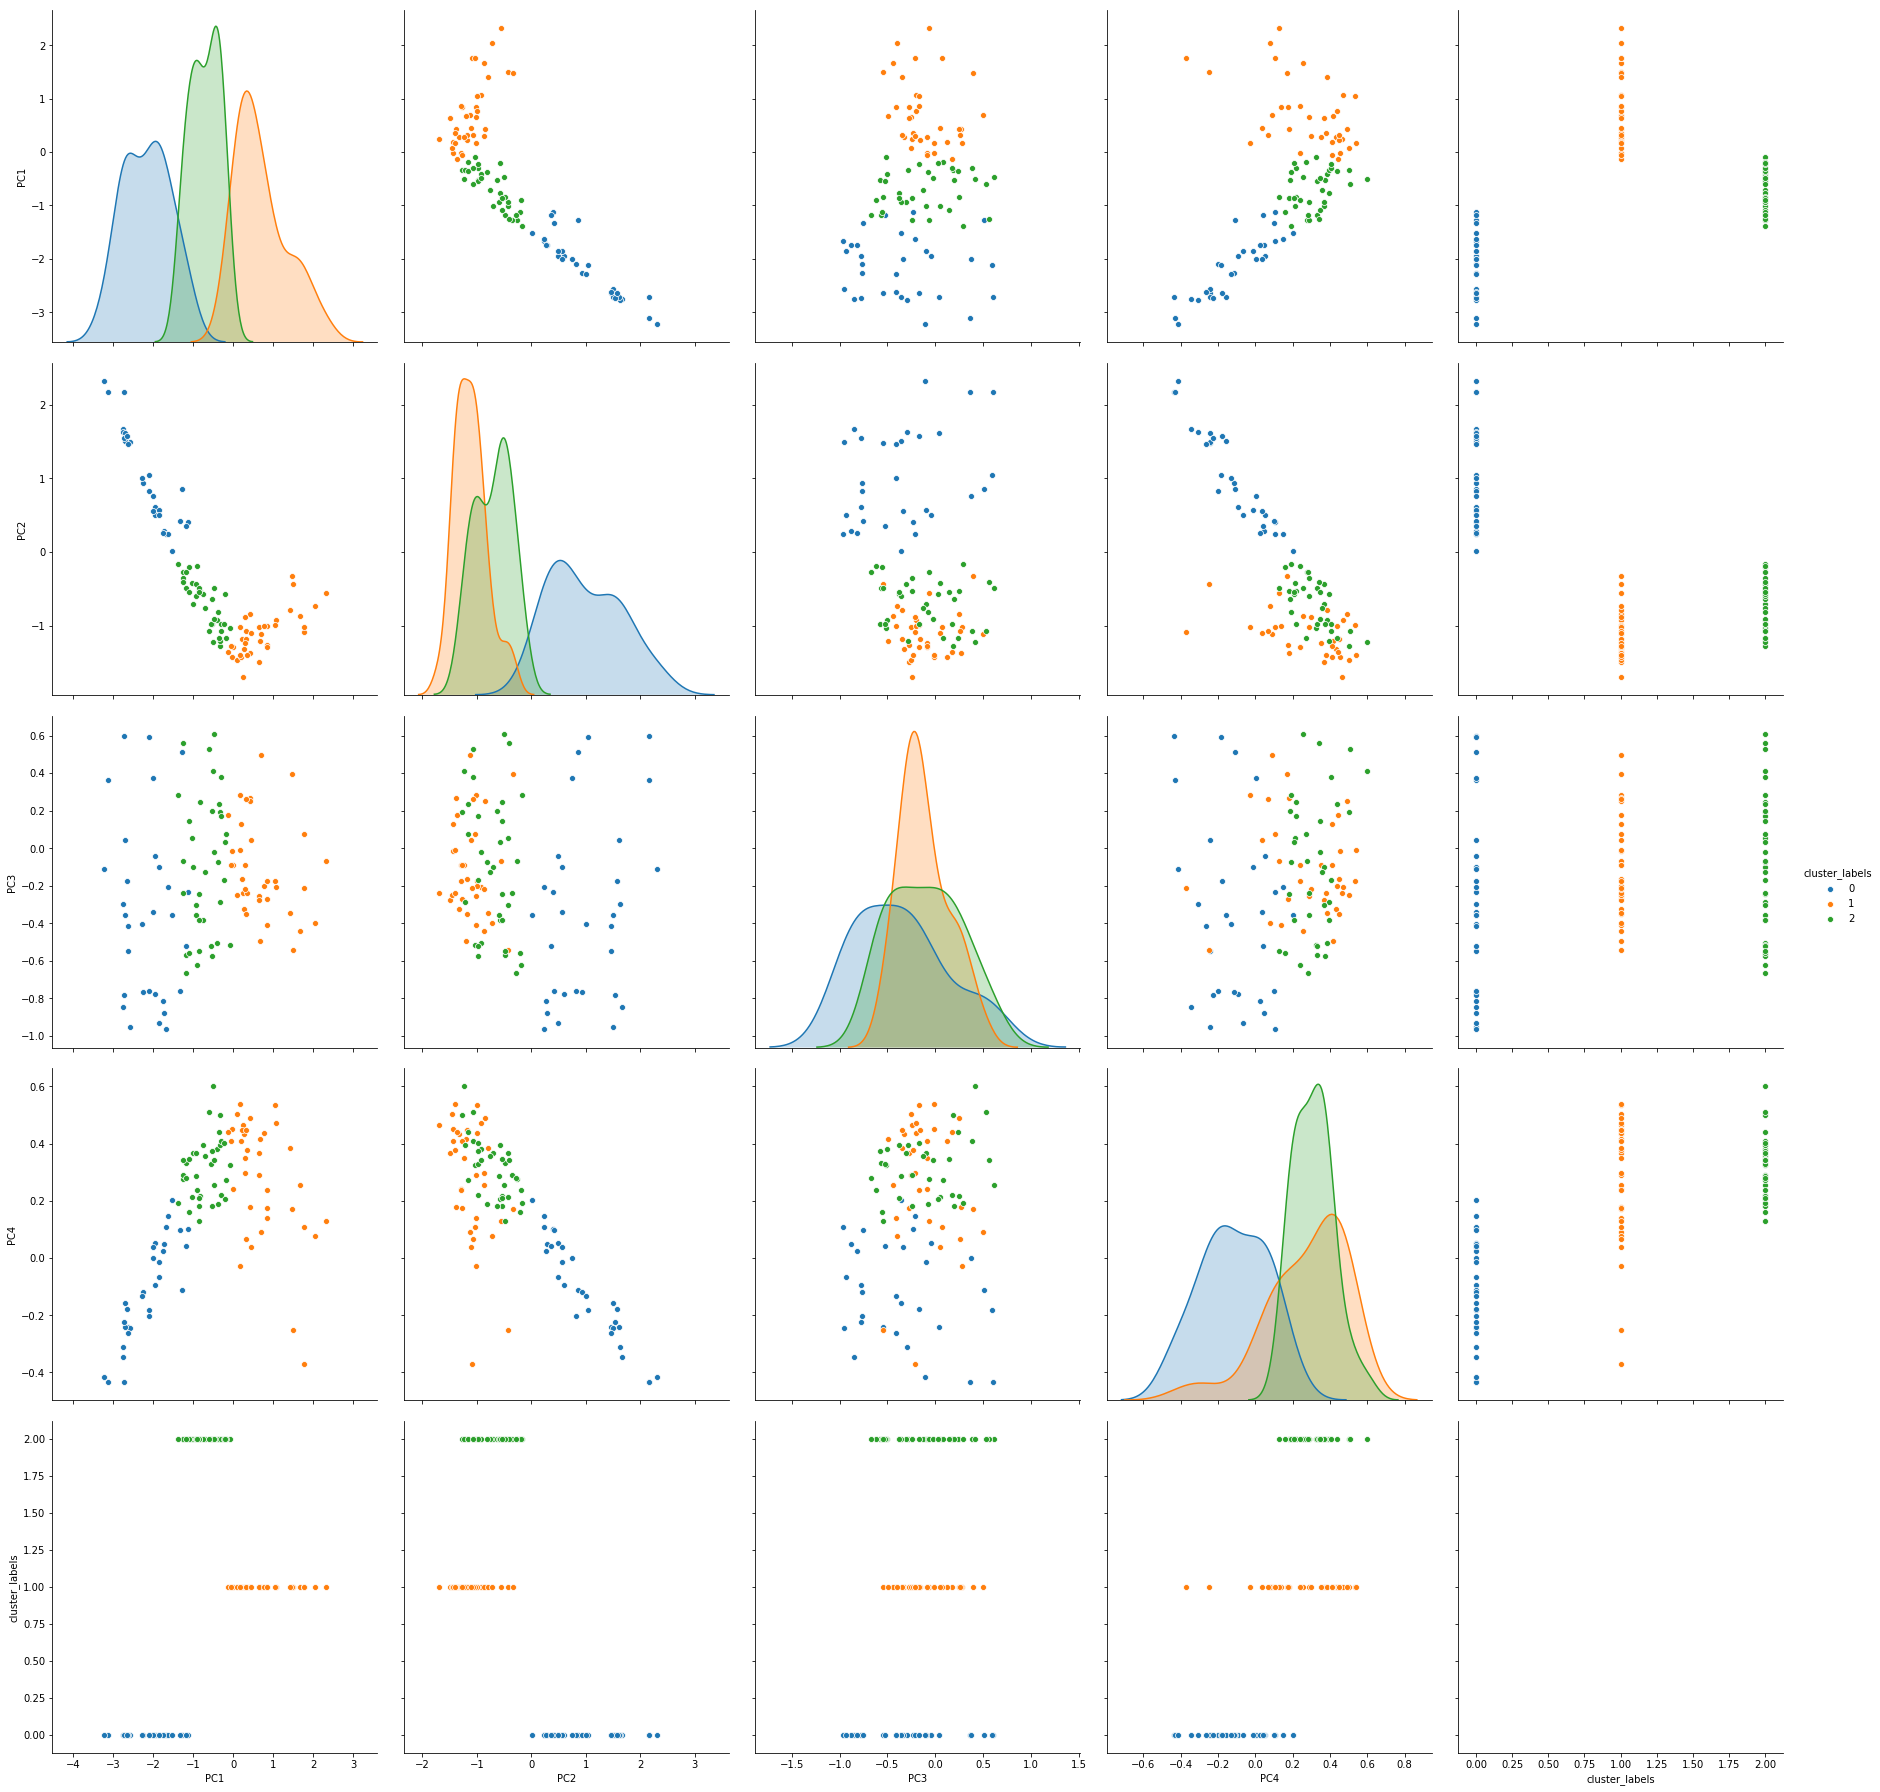

In [52]:
sns.pairplot(data=df_cl,hue = "cluster_labels", size=5)

In [53]:
df_cl=df_cl.merge(df, on= 'country')
df_cl.head()

,country,PC1,PC2,PC3,PC4,cluster_labels,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,-0.024206,-1.429892,-0.014123,0.450645,1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Angola,-2.722630,2.172332,0.600215,-0.433978,0,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
3,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,1,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200
4,Armenia,-0.334555,-1.271889,0.190564,0.500247,2,18.1,669.76,141.6800,1458.660,6700,7.77,73.3,1.69,3220


In [54]:
df_cl.drop(['PC1','PC2','PC3','PC4'],axis=1,inplace=True)

In [55]:
df_cl.head()

,country,cluster_labels,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Angola,0,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
3,Antigua and Barbuda,1,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200
4,Armenia,2,18.1,669.76,141.6800,1458.660,6700,7.77,73.3,1.69,3220


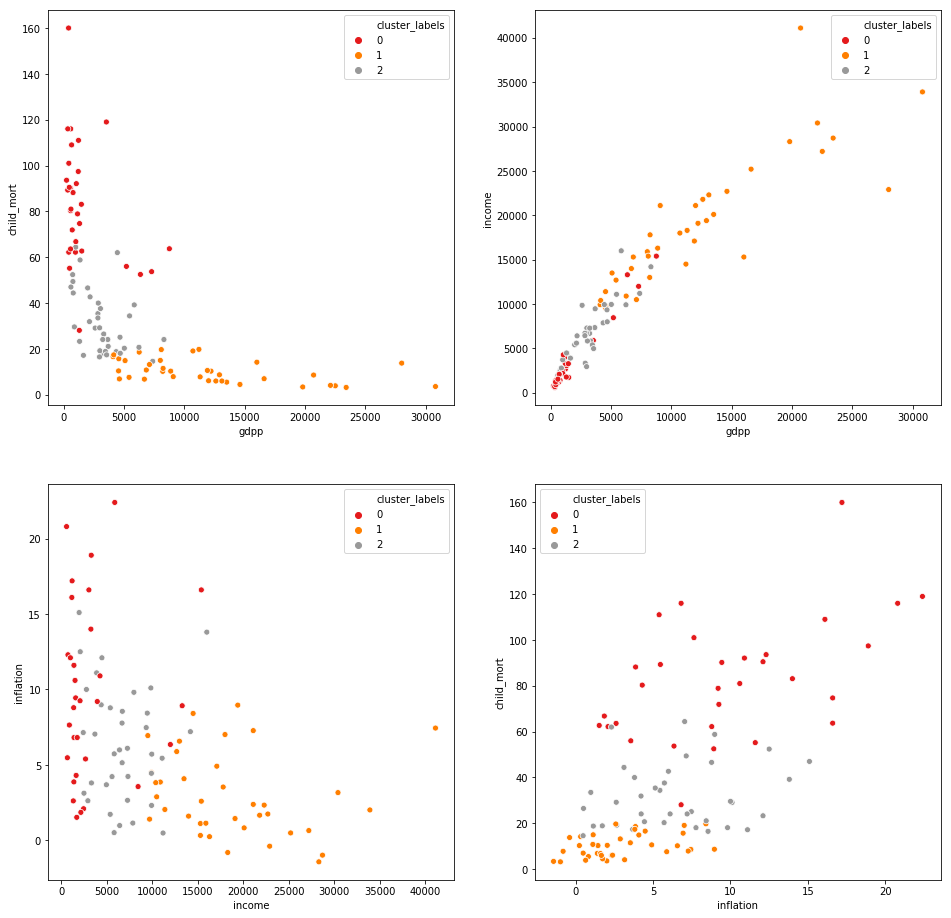

In [56]:
# Visualising separation of important variables in different clusters
fig,axes = plt.subplots(2,2,squeeze=False, figsize = (16, 16))

sns.scatterplot(x="gdpp", y="child_mort",data=df_cl, hue = "cluster_labels", palette="Set1",ax=axes[0][0])
sns.scatterplot(x="gdpp", y="income",data=df_cl, hue = "cluster_labels",palette="Set1",ax=axes[0][1])
sns.scatterplot(x="income", y="inflation",data=df_cl, hue = "cluster_labels",palette="Set1", ax=axes[1][0])
sns.scatterplot(x="inflation", y="child_mort",data=df_cl, hue = "cluster_labels",palette="Set1", ax=axes[1][1])


### Cluster profile

In [57]:
# Cheking the profile of cluster formed by k-means algorithm.
#Since gdpp and income was highly correlated in the original dataframe, only the distribution of child mortality and gdpp are analysed
df_kmeans_3.groupby('cluster_id')['child_mort','gdpp'].describe().reset_index()

cluster_id child_mort                                                     \
                  count       mean        std   min     25%    50%     75%   
0          0       37.0  10.262162   5.050102   3.2   6.100  10.20  14.200   
1          1       28.0  86.985714  23.828286  55.2  66.025  85.65  98.300   
2          2       40.0  32.750000  14.107154  14.6  20.600  29.15  43.125   

          gdpp                                                                \
     max count          mean          std     min      25%      50%      75%   
0   19.8  37.0  12044.324324  6894.605597  4090.0  6840.00  11200.0  14600.0   
1  160.0  28.0   1297.428571  1789.749898   231.0   476.25    675.0   1205.0   
2   64.4  40.0   3343.550000  1987.780284   592.0  1892.50   3015.0   4495.0   

            
       max  
0  30800.0  
1   8750.0  
2   8300.0

In [58]:
# Cheking the profile of cluster formed by Hierarchical complete linkaage algorithm.
#Since gdpp and income was highly correlated in the original dataframe, only the distribution of child mortality and gdpp are analysed
df_cl.groupby('cluster_labels')['child_mort','gdpp'].describe().reset_index()

cluster_labels child_mort                                                 \
                      count       mean        std   min    25%   50%   75%   
0              0       31.0  82.900000  26.190011  28.1  63.15  81.0  95.5   
1              1       37.0  10.262162   5.050102   3.2   6.10  10.2  14.2   
2              2       37.0  31.775676  13.820022  14.6  20.30  29.1  40.0   

          gdpp                                                               \
     max count          mean          std     min     25%      50%      75%   
0  160.0  31.0   1653.161290  2190.002300   231.0   517.5    769.0   1300.0   
1   19.8  37.0  12044.324324  6894.605597  4090.0  6840.0  11200.0  14600.0   
2   64.4  37.0   3211.405405  1861.167487   592.0  1980.0   2990.0   4340.0   

            
       max  
0   8750.0  
1  30800.0  
2   8300.0

From the above scatter plot visualizations and cluster profiling, it is clear that almost similar clusters are created using k-means and complete linkage hierarchical clustering algorithm. Since the standard deviation for few variables are lesser in k-means clustering than in hierarchical clustering, clusters formed using k-means are taken for analysis

The countries that are removed as outliers are added back to the dataframe by assigning cluster ids based on their gdpp

In [59]:
#df_out.drop(['PC1','PC2','PC3','PC4'],axis=1,inplace=True)
df_out=df_out.merge(df,how='inner',on='country') # Merging all the columns corresponding to outlier values
df_out.head()


,country,PC1,PC2,PC3,PC4,cluster_id,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Algeria,NaN,NaN,NaN,NaN,NaN,27.3,1712.64,185.982,1400.44,12900,16.100,76.5,2.89,4460
1,Argentina,NaN,NaN,NaN,NaN,NaN,14.5,1946.70,834.300,1648.00,18700,20.900,75.8,2.37,10300
2,Australia,NaN,NaN,NaN,NaN,NaN,4.8,10276.20,4530.870,10847.10,41400,1.160,82.0,1.93,51900
3,Austria,NaN,NaN,NaN,NaN,NaN,4.3,24059.70,5159.000,22418.20,43200,0.873,80.5,1.44,46900
4,Belarus,NaN,NaN,NaN,NaN,NaN,5.5,3099.42,338.283,3889.35,16200,15.100,70.4,1.49,6030


# Merging all the columns corresponding to outlier values
df_out=df_out.merge(df,how='inner',on='country')
df_out.head()

In [60]:
# Assigning conditions for manually assigning cluster ids
conditions=  [df_out['gdpp']<=1205, (df_out['gdpp']>1205) &(df_out['gdpp']<=4390),df_out['gdpp']> 4390] 
values = [0, 1, 2]
df_out['cluster_id']=np.where(df_out['cluster_id'].isnull(),np.select(conditions, values),df_out['cluster_id'])
df_out.head()

,country,PC1,PC2,PC3,PC4,cluster_id,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Algeria,NaN,NaN,NaN,NaN,2.0,27.3,1712.64,185.982,1400.44,12900,16.100,76.5,2.89,4460
1,Argentina,NaN,NaN,NaN,NaN,2.0,14.5,1946.70,834.300,1648.00,18700,20.900,75.8,2.37,10300
2,Australia,NaN,NaN,NaN,NaN,2.0,4.8,10276.20,4530.870,10847.10,41400,1.160,82.0,1.93,51900
3,Austria,NaN,NaN,NaN,NaN,2.0,4.3,24059.70,5159.000,22418.20,43200,0.873,80.5,1.44,46900
4,Belarus,NaN,NaN,NaN,NaN,2.0,5.5,3099.42,338.283,3889.35,16200,15.100,70.4,1.49,6030


In [61]:
df_kmeans=pd.concat([df_out,df_kmeans_3]) # Concatenating with original clustered dataframe
df_kmeans.shape

(167, 15)

In [62]:
df_kmeans.drop(['PC1','PC2','PC3','PC4'],axis=1,inplace=True)
df_kmeans.head()

,country,cluster_id,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Algeria,2.0,27.3,1712.64,185.982,1400.44,12900,16.100,76.5,2.89,4460
1,Argentina,2.0,14.5,1946.70,834.300,1648.00,18700,20.900,75.8,2.37,10300
2,Australia,2.0,4.8,10276.20,4530.870,10847.10,41400,1.160,82.0,1.93,51900
3,Austria,2.0,4.3,24059.70,5159.000,22418.20,43200,0.873,80.5,1.44,46900
4,Belarus,2.0,5.5,3099.42,338.283,3889.35,16200,15.100,70.4,1.49,6030


### Finding the Countries that are in the direst need of aid

In [63]:
# Cheking the profile of cluster formed by k-means algorithm again after merging outliers
df_kmeans.groupby('cluster_id')['child_mort','gdpp'].describe().reset_index()

cluster_id child_mort                                                     \
                  count       mean        std   min     25%    50%     75%   
0        0.0       46.0  33.950000  51.005258   3.2   6.925  10.70  18.975   
1        1.0       39.0  78.248718  31.367817  11.2  62.400  78.90  95.500   
2        2.0       82.0  21.679268  19.169335   2.6   5.275  17.75  29.500   

          gdpp                                                              \
     max count          mean           std    min     25%     50%      75%   
0  208.0  46.0   9818.782609   7671.691289  348.0  4545.0  8215.0  13050.0   
1  160.0  39.0   1590.205128   1637.016464  231.0   562.5  1140.0   1910.0   
2  111.0  82.0  20138.195122  23119.468277  592.0  3085.0  6905.0  37825.0   

             
        max  
0   30800.0  
1    8750.0  
2  105000.0

In [64]:
df_kmeans['cluster_id']=df_kmeans['cluster_id'].astype(int) # Changing cluster id to int type

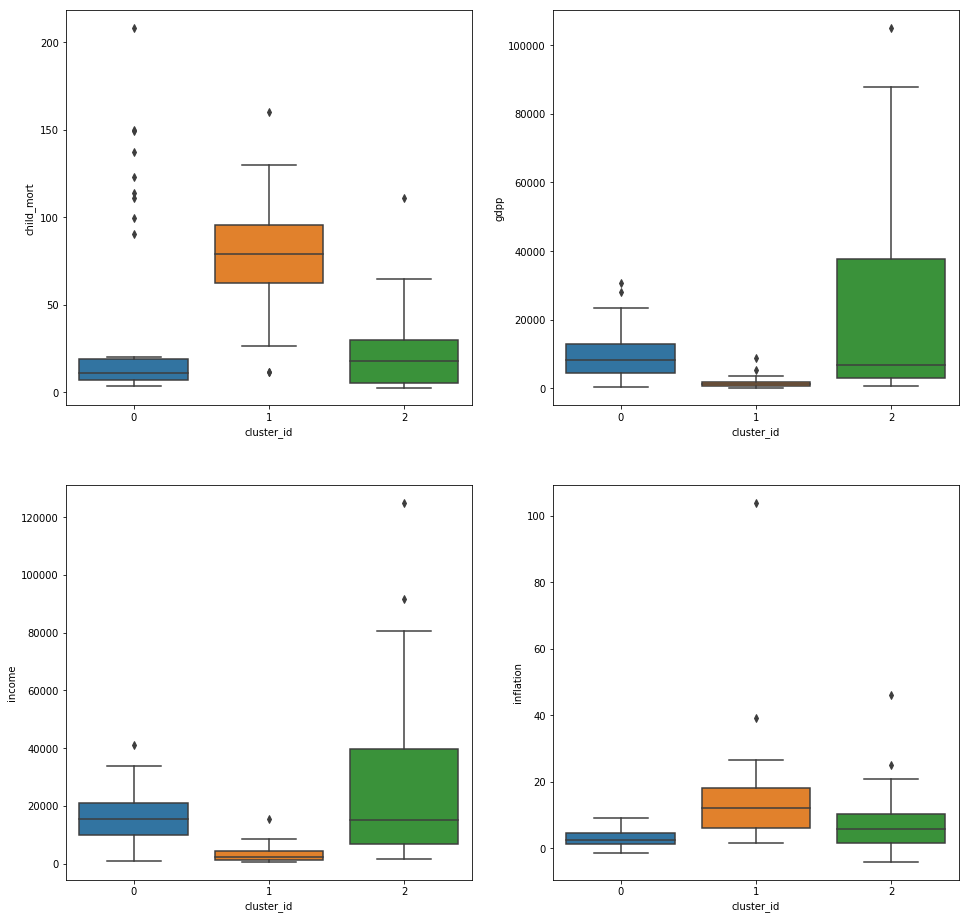

In [65]:
# Plotting the distribution
fig,axes = plt.subplots(2,2,squeeze=False, figsize = (16, 16))
sns.boxplot(x='cluster_id', y='child_mort', data=df_kmeans, ax=axes[0][0])
sns.boxplot(x='cluster_id', y='gdpp', data=df_kmeans, ax=axes[0][1])
sns.boxplot(x='cluster_id', y='income', data=df_kmeans, ax=axes[1][0])
sns.boxplot(x='cluster_id', y='inflation', data=df_kmeans, ax=axes[1][1])

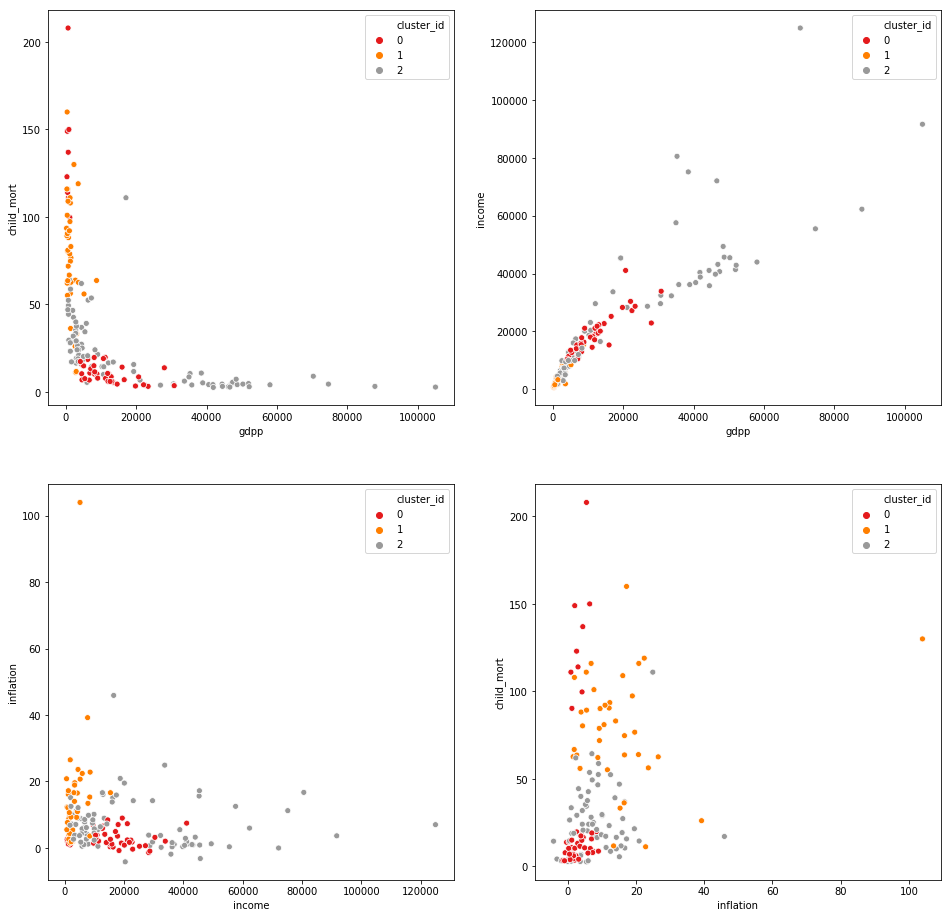

In [66]:
# Scatter plot
fig,axes = plt.subplots(2,2,squeeze=False, figsize = (16, 16))

sns.scatterplot(x="gdpp", y="child_mort",data=df_kmeans, hue = "cluster_id",ax=axes[0][0],palette='Set1')
sns.scatterplot(x="gdpp", y="income",data=df_kmeans,hue = "cluster_id",palette='Set1',ax=axes[0][1])
sns.scatterplot(x="income", y="inflation",data=df_kmeans, hue = "cluster_id",palette='Set1',ax=axes[1][0])
sns.scatterplot(x="inflation", y="child_mort",data=df_kmeans, hue = "cluster_id",palette='Set1',ax=axes[1][1])

From the above visualizations, it is clear that countries belonging to cluster 0 requires aid, as they have the highest child mortality rate,the lowest gdpp and the lowest income. So the countries in cluster 0 with direst need of aid are to be identified

In [67]:
# Determining thr number of countries in cluster 0
df_kmeans['cluster_id'].value_counts()

2    82
0    46
1    39
Name: cluster_id, dtype: int64

In [68]:
# Selecting countries in belonging to cluster 0:
df_need=df_kmeans.loc[df_kmeans['cluster_id']==0]
df_need=df_need.set_index('country')
df_need.drop('cluster_id',axis=1,inplace=True)
df_need.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Benin,111.0,180.404,31.0780,281.976,1820,0.885,61.8,5.36,758
Central African Republic,149.0,52.628,17.7508,118.190,888,2.010,47.5,5.21,446
Chad,150.0,330.096,40.6341,390.195,1930,6.390,56.5,6.59,897
Guinea-Bissau,114.0,81.503,46.4950,192.544,1390,2.970,55.6,5.05,547
Haiti,208.0,101.286,45.7442,428.314,1500,5.450,32.1,3.33,662


In [69]:
df_need.describe(percentiles=[.10,.25, .5, .75,0.9])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,33.950000,4783.959413,733.837093,5044.704761,15403.956522,3.032196,71.826087,2.414783,9818.782609
std,51.005258,4517.615702,620.266304,4400.343827,9521.967374,2.612237,10.378063,1.588317,7671.691289
min,3.200000,52.628000,17.750800,118.190000,814.000000,-1.430000,32.100000,1.230000,348.000000
10%,4.300000,170.914000,38.983050,280.800000,1660.000000,0.279500,57.600000,1.395000,685.000000
25%,6.925000,1198.620000,259.794250,1488.135000,10047.500000,1.142500,73.475000,1.520000,4545.000000
50%,10.700000,3275.040000,615.703000,3831.450000,15350.000000,2.465000,76.000000,1.775000,8215.000000
75%,18.975000,6625.625000,1005.252500,7640.450000,21100.000000,4.460000,76.875000,2.157500,13050.000000
90%,118.500000,11815.200000,1545.885000,11386.150000,27750.000000,6.975000,79.650000,5.130000,21400.000000
max,208.000000,15461.600000,2475.000000,17710.000000,41100.000000,8.960000,80.400000,7.490000,30800.000000


***To find the countries  in need, we have to select the countries with income less than 25 percentile (1220), gdpp less than 25 percentile (482), child mortality rate greater than 75 percentile (114) ***

In [70]:
df_need.loc[df_need['child_mort']>111].sort_values(by='gdpp')

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Niger,123.0,77.256,17.9568,170.868,814,2.55,58.8,7.49,348
Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446
Guinea-Bissau,114.0,81.503,46.4950,192.544,1390,2.97,55.6,5.05,547
Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662
Mali,137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708
Chad,150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897


Text(0, 0.5, 'Child mortality rate')

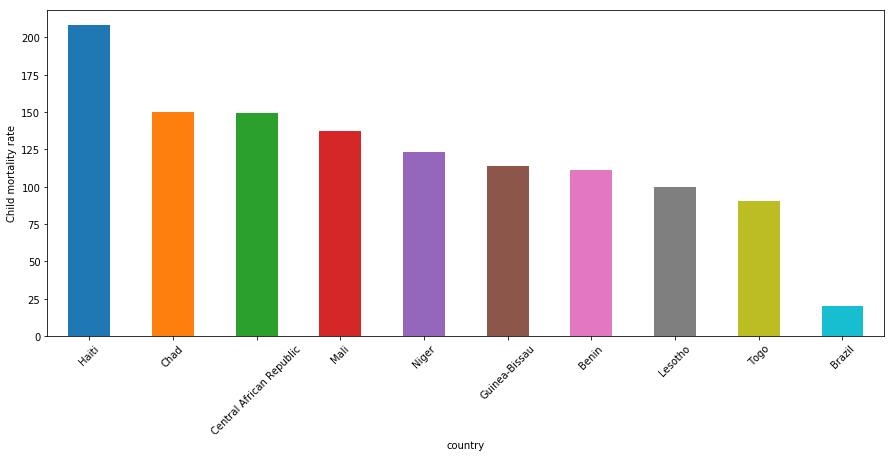

In [71]:
# Plotting countries with highest child mortality rate
fig = plt.figure(figsize=(15,6))
df_need['child_mort'].sort_values(ascending=False)[0:10].plot(y=df_need['child_mort'],kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Child mortality rate')

Text(0, 0.5, 'gdpp')

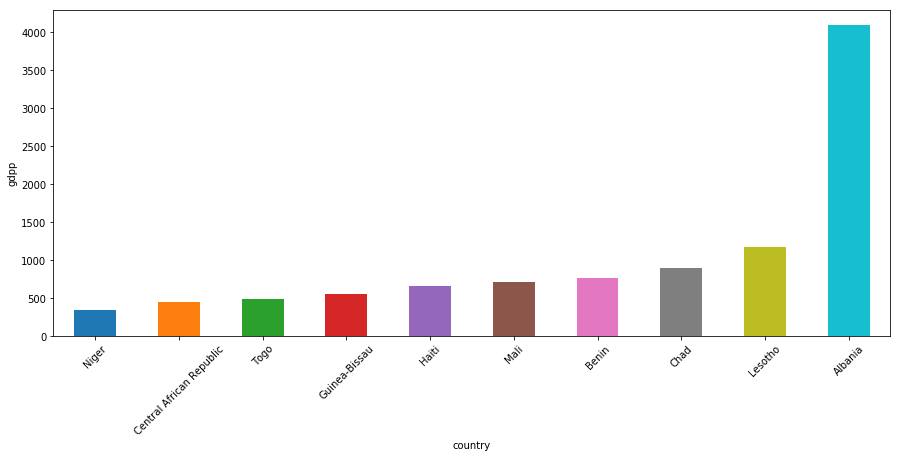

In [72]:
# Plotting countries with lowest gdpp
fig = plt.figure(figsize=(15,6))
df_need['gdpp'].sort_values()[0:10].plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('gdpp')

Text(0, 0.5, 'Income')

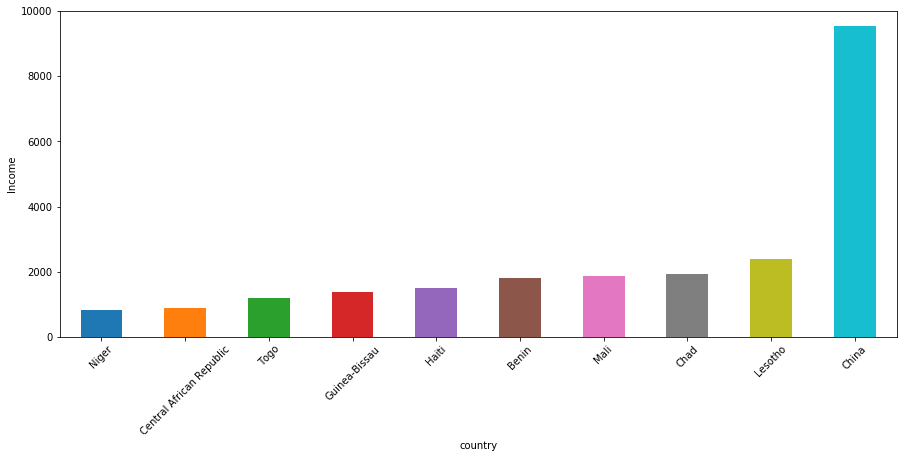

In [73]:
# Plotting countries with lowest income
fig = plt.figure(figsize=(15,6))
df_need['income'].sort_values()[0:10].plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Income')